In [1]:
import pandas as pd
import numpy as np
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator
import random

import torch

from tqdm import tqdm

%matplotlib inline

/home/ubuntu/venvs/pnma/lib/python3.10/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-64g-actorder_True"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main",
                                            output_hidden_states=True)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
model.to("cuda")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (rotary_emb): LlamaRotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): LlamaMLP(
          (act_fn): SiLUActivation()
          (down_proj): QuantLinear()
          (gate_proj): QuantLinear()
          (up_proj): QuantLinear()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)

In [3]:
instructions = "Answer only with 'yes' or 'no'. Other answers will be discarded."
prompt = "Was RA Fisher a great man?"

prompt_template = f'''<s>[INST] <<SYS>>
{instructions}
<</SYS>>

{prompt} [/INST]
'''

input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0.9, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=3)
print(tokenizer.decode(output[0]))

/home/ubuntu/venvs/pnma/lib/python3.10/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<s><s>[INST] <<SYS>>
Answer only with 'yes' or 'no'. Other answers will be discarded.
<</SYS>>

Was RA Fisher a great man? [/INST]
Yes</s>


In [4]:
fisher_data_file_path = '/home/ubuntu/pnma/files/RA-Fisher.csv'
fisher_data = pd.read_csv(fisher_data_file_path)
strings = fisher_data['string']
labels = fisher_data['label']

In [5]:
def get_response(model, input_ids, tokenizer, generate_kwargs={'max_new_tokens': 3}):    
    output = model.generate(inputs=input_ids, **generate_kwargs)
    response = tokenizer.decode(output[0])

    response = response.split('[/INST]')[-1]
    response = response.split('</s>')[0]
    response = response.lower()

    response = response.split(' ')[-1]
    response = response.split('.')[0]

    return response
    

def get_embedding(model, input_ids):
    output =  model(input_ids)
    embedding = np.mean(output.hidden_states[0].detach().cpu().numpy(), axis=1).flatten()
    
    return embedding


def get_formatted_prompt(prompt, context="", instruction=None):
    if instruction is None:
        instruction = "Answer only with 'yes' or 'no' in English."

    if len(context) == 0:
        context_and_prompt = prompt

    else:
        context_and_prompt = f'{context} {prompt}'

    formatted_prompt = f'''<s>[INST] <<SYS>>
        {instruction}
        <</SYS>>
        
        {context_and_prompt} [/INST]'''

    return formatted_prompt
    

def get_strings_stratified(strings, labels, n=10, S=10):
    if S > n:
        S = n
    
    unique_labels = np.unique(labels)
    
    stats_strings_indices = np.random.choice(np.where(labels==unique_labels[1])[0], S, replace=True) 
    eugenics_strings_indices = np.random.choice(np.where(labels==unique_labels[0])[0], n-S, replace=True)

    selected_strings = [strings[i] for i in stats_strings_indices] + [strings[i] for i in eugenics_strings_indices]
    random.shuffle(selected_strings)
        
    return selected_strings


def combine_strings(string_list):
    s = ""
    for s_ in string_list:
        s += " " + s_

    return s[1:]


def get_context_and_prompt(prompt, strings, labels, C=2, S=2):
    string_list = get_strings_stratified(strings, labels, C, S)
    context_string = combine_strings(string_list)

    return context_string + " " + prompt

In [6]:
np.random.seed(1)

NO_LIST = [b'no', b'\xe2\x9d\x8c', b'\xe2\x98\xb9', b'\xf0\x9f\x98\x90']
YES_LIST = [b'yes', b'\xf0\x9f\x98\x8a']

skip_words = ['not', 'was']
embeddings = []
phats = []
STOP=False
n_responses = 25

generate_kwargs = {
    'temperature':0.9, 
    'do_sample':True, 
    'top_p':0.95, 
    'top_k':40, 
    'max_new_tokens':10
}

n_sentences_list = [0, 1]

embeddings = {}
phats = {}

for i, n_sentences in enumerate(n_sentences_list):
    print(f'starting {n_sentences}')
    embeddings[n_sentences] = {}
    phats[n_sentences] = {}

    for S in range(n_sentences+1):
        embeddings[n_sentences][S] = []
        phats[n_sentences][S] = []

        if n_sentences == 0:
            paragraphs = [""]
        elif n_sentences == 1:
            paragraphs = strings[::-1][S*25:(S+1)*25]
        else:
            paragraphs = [get_context_and_prompt("", strings, labels, n_sentences, S) for i in range(n_paragraphs)]
        
        for string in tqdm(paragraphs):
            formatted_prompt = get_formatted_prompt(prompt, context=string)

            input_ids = tokenizer(formatted_prompt, return_tensors='pt').input_ids.cuda()
        
            embedding = get_embedding(model, input_ids)
            embeddings[n_sentences][S].append(embedding)
        
            c=0
            phat=0
            max_c=100
            while c<n_responses and c<max_c:
                response = get_response(model, input_ids, tokenizer, generate_kwargs)
        
                # print(response)
        
                if response.encode('utf-8') in YES_LIST:
                    c+=1
                    phat+=1
                elif response.encode('utf-8') in NO_LIST:
                    c+=1
        
            phat /= c
            phats[n_sentences][S].append(phat)

starting 0


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


starting 1


100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [01:59<00:00,  4.77s/it]


In [11]:
import pickle

# embeddings_and_phats = {'embeddings': embeddings, 'phats': phats}
# pickle.dump(embeddings_and_phats, open('/home/ubuntu/data/embeddings_and_phats.p', 'wb'))
# embeddings_and_phats = pickle.load(open('/home/ubuntu/data/embeddings_and_phats.p', 'rb'))
# embeddings = embeddings_and_phats['embeddings']
# phats = embeddings_and_phats['phats']

Text(0, 0.5, 'P(yes)')

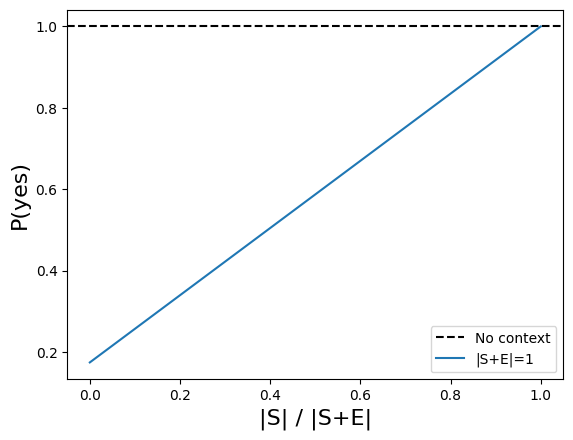

In [12]:
fig, ax = plt.subplots(1,1)

ax.axhline(y=phats[0][0], c='k', ls='--', label='No context')

for i, n_sentences in enumerate(n_sentences_list[1:]):
    average_phat = []
    for S in range(n_sentences+1):
        average_phat.append(np.mean(phats[n_sentences][S]))
    ax.plot(np.arange(n_sentences+1) / n_sentences, average_phat, label=f'|S+E|={n_sentences}')

ax.legend()
ax.set_xlabel('|S| / |S+E|', fontsize=16)
ax.set_ylabel('P(yes)', fontsize=16)

In [13]:
if len(n_sentences_list) == 7:
    fig, ax = plt.subplots(2, 3, figsize=(7, 7))
    
    for i, n_sentences in enumerate(n_sentences_list[1:]):
        row, col = i // 3, i % 3
    
        embds = []
        ells = []
        for S in range(n_sentences+1):
            temp = np.array(embeddings[n_sentences][S])
            embds.append(temp)
            ells.append((S+1)*np.ones(len(temp)))
        
        embds = np.vstack(embds)
        ells = np.hstack(ells)
        
        mds = ClassicalMDS(n_components=2)
        cmds_embds = mds.fit_transform(embds)
        
        
        ax[row, col].scatter(cmds_embds[:, 0], cmds_embds[:, 1], alpha=ells / (n_sentences+1))
    # ax.set_xlabel("MDS dim 1")
    # ax.set_ylabel("MDS dim 2")
    # ax.legend(frameon=True, fontsize=16)
    # plt.show()

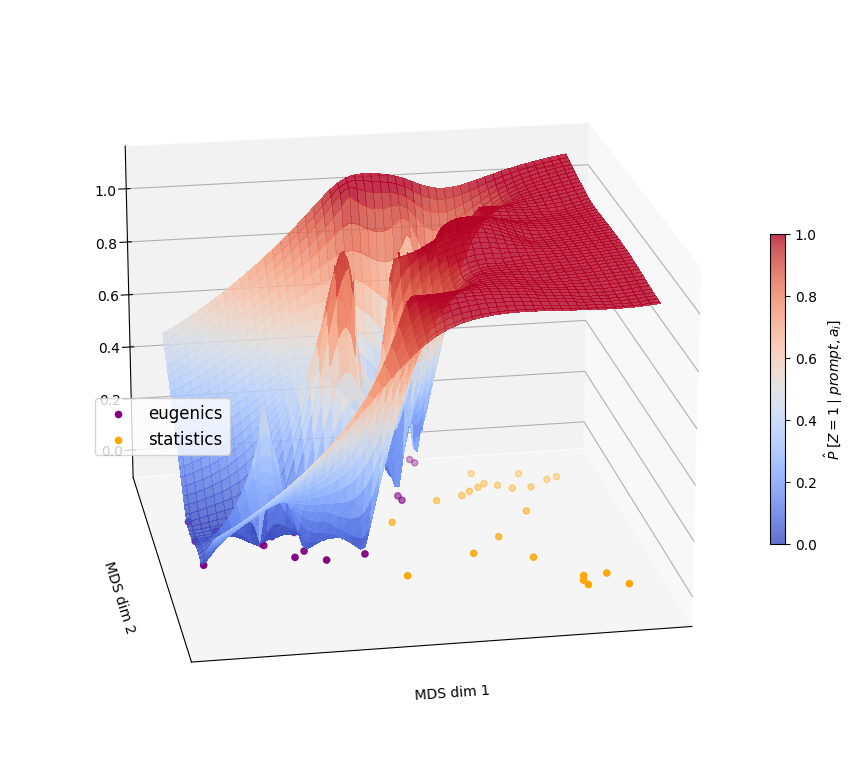

In [14]:
n_sentences=1

embds = []
ells = []
p = []
for S in range(n_sentences+1):
    temp = np.array(embeddings[n_sentences][S])
    embds.append(temp)
    ells.append((S+1)*np.ones(len(temp)))
    p.append(phats[n_sentences][S])

embds = np.vstack(embds)
ells = np.hstack(ells)
p = np.hstack(p)

mds = ClassicalMDS(n_components=2)
cmds_embds = mds.fit_transform(embds)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xg, yg = np.meshgrid(cmds_embds[:, 0], cmds_embds[:, 1], indexing='ij')
interp = RBFInterpolator(cmds_embds, p, kernel='linear', smoothing=0)

xx = np.linspace(-0.03, 0.03, 100)
yy = np.linspace(-0.03, 0.03, 100)
X, Y = np.meshgrid(xx, yy, indexing='ij')

grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
vals = interp(grid)

C = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.8)

ax.scatter(cmds_embds[:, 0][ells == 1], cmds_embds[:, 1][ells == 1], 0, c='purple', label='eugenics')
ax.scatter(cmds_embds[:, 0][ells == 2], cmds_embds[:, 1][ells == 2], 0, c='orange', label='statistics')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.colorbar(C, ax=ax, fraction=0.02, pad=0, label=r'$\hat P \;[Z=1 \mid prompt, a_i]$')
ax.legend(frameon=True, fontsize=12, bbox_to_anchor=(0.3, 0.5))
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
ax.view_init(elev=20, azim=80, roll=0)

ax.set_xticks([])
ax.set_yticks([])

plt.show()